In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
warnings.simplefilter(action='ignore')

In [2]:
data_train_final = pd.read_csv('data_train_final.csv')
data_test_final = pd.read_csv('data_test_final.csv')

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense
import keras_nlp

In [6]:
# Prepare baskets
def prepare_baskets(data):
    return data.groupby("order_id")["product_id"].apply(list).tolist()

train_baskets = prepare_baskets(data_train_final)
test_baskets = prepare_baskets(data_test_final)

train_baskets, val_baskets = train_test_split(train_baskets, test_size=0.25, random_state=42)

max_len = max(len(basket) for basket in train_baskets + val_baskets + test_baskets)

In [7]:
D = 32
batch_size = 256
max_epochs = 1000
lr = 1e-4
max_items = len(set(data_train_final['product_id']))

In [8]:
def preprocess_baskets(baskets):
    context_inputs = []
    target_inputs = []
    masked_idxs = []

    for basket in baskets:
        for idx, elt in enumerate(basket):
            target_inputs.append(elt)
            context_inputs.append(basket[:idx] + [max_items + 1] + basket[(idx+1):])
            masked_idxs.append(idx)

    context_inputs = pad_sequences(context_inputs, padding='post', maxlen = max_len, value=0)
    return np.array(context_inputs), np.array(target_inputs) - 1, np.array(masked_idxs)

train_context_input, train_target_input, train_masked_idxs = preprocess_baskets(train_baskets)
val_context_input, val_target_input, val_masked_idxs = preprocess_baskets(val_baskets)
test_context_input, test_target_input, test_masked_idxs = preprocess_baskets(test_baskets)

In [24]:
input_context = layers.Input(shape=(max_len,), dtype=tf.int32, name="context_input")
masked_idx_input = layers.Input(shape=(1,), dtype=tf.int32, name="masked_idx_input")

alpha_embedding = layers.Embedding(input_dim=max_items + 2, output_dim=D, name="alpha_embedding")
context_embedding = alpha_embedding(input_context)

class ZeroMaskEmbedding(layers.Layer):
    def call(self, embeddings, input_tokens):
        mask = tf.cast(tf.not_equal(input_tokens, 0), tf.float32)
        mask = tf.expand_dims(mask, axis=-1)
        return embeddings * mask

context_embedding = ZeroMaskEmbedding()(context_embedding, input_context)

class MaskLayer(layers.Layer):
    def call(self, input_context, position):
        return position * tf.expand_dims(tf.cast(tf.not_equal(input_context, 0), tf.float32), axis = -1)

position = keras_nlp.layers.PositionEmbedding(sequence_length=max_len)(context_embedding)
masked_position = MaskLayer()(input_context, position)
context_embedding = context_embedding + masked_position

attention_layer_1 = MultiHeadAttention(num_heads=2, key_dim=16, name="multi_head_attention_1")
attn_output_1 = attention_layer_1(
    query=context_embedding,
    value=context_embedding,
    key=context_embedding,
    use_causal_mask=True,
    return_attention_scores=True
)

attn_output_1 = context_embedding + attn_output_1[0]

attention_layer_2 = MultiHeadAttention(num_heads=2, key_dim=16, name="multi_head_attention_2")
attn_output_2 = attention_layer_2(
    query=attn_output_1,
    value=attn_output_1,
    key=attn_output_1,
    use_causal_mask=True,
    return_attention_scores=True
)

context_embedding = attn_output_1 + attn_output_2[0]

class GatherLayer(layers.Layer):
    def call(self, inputs):
        context_embedding, masked_idx_input = inputs
        return tf.gather(context_embedding, indices=tf.squeeze(masked_idx_input, axis=-1), batch_dims=1)

masked_embeddings = GatherLayer()([context_embedding, masked_idx_input])

output = layers.Dense(max_items, activation="softmax", name="output_layer", use_bias = False)(masked_embeddings)

model = Model(inputs=[input_context, masked_idx_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="sparse_categorical_crossentropy")

early_stopping = EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

history = model.fit(
    [train_context_input, train_masked_idxs], train_target_input,
    validation_data=([val_context_input, val_masked_idxs], val_target_input),
    batch_size=batch_size,
    epochs=max_epochs,
    callbacks=[early_stopping]
)

Epoch 1/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4.0897 - val_loss: 3.9716
Epoch 2/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.9658 - val_loss: 3.9495
Epoch 3/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9465 - val_loss: 3.9409
Epoch 4/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.9437 - val_loss: 3.9328
Epoch 5/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9329 - val_loss: 3.9226
Epoch 6/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9225 - val_loss: 3.9096
Epoch 7/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9057 - val_loss: 3.8964
Epoch 8/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.8972 - val_loss: 3.8874
Epoch 9/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.8863 - val_loss: 3.8819
Epoch 10/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8813 - val_loss: 3.8774
Epoch 11/1000
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8778 - val_loss: 3.8748
Epoch 12/1000
807/807 ━━━━━━━

In [105]:
products = pd.read_csv('products.csv')
products_dict = {}
for i in range(products.shape[0]):
    products_dict[products['product_id'][i]] = products['product_name'][i]

product_ids = [21903, 30391, 46667, 13176, 21616,  8518, 22935,  5876, 48679,
       24838, 31717, 47209, 26209, 34969, 27966, 37646, 44632, 16797,
       39275,  5077, 10749, 49235, 21137, 28204, 21938, 46979, 47626,
       44359, 34126, 28985, 24852, 41950, 30489,  9076, 24964, 45007,
       42265, 49683, 47766, 39877, 19057, 40706,  5450, 43961, 39928,
       22825, 12341, 17794,  4605, 22035, 27845, 27104, 26604,  8277,
        4920, 25890, 31506, 35951, 45066, 24184, 19660, 27086, 43352]

all_products = []
for i in product_ids:
    all_products.append(products_dict[i])

**VISUALIZING ATTENTION WEIGHTS**

In [48]:
def get_attention_scores(model, new_context_input, new_masked_idx_input):

  intermediate_outputs = [layer.output for layer in model.layers if 'multi_head_attention' in layer.name]
  attention_model = Model(inputs=model.inputs, outputs=intermediate_outputs)

  attention_outputs = attention_model.predict([new_context_input, new_masked_idx_input])

  attention_scores_1 = attention_outputs[0][-1]
  attention_scores_2 = attention_outputs[1][-1]

  return attention_scores_1, attention_scores_2

In [171]:
new_context_input = test_context_input[15:25]
new_masked_idx_input = test_target_input[15:25]

attention_scores_1, attention_scores_2 = get_attention_scores(model, new_context_input, new_masked_idx_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


In [172]:
basket = [13, 27,  1, 23, 26, 19, 29,  2, 28, 3]

basket = [all_products[i-1] for i in basket]

In [173]:
basket

['Limes',
 'Large Lemon',
 'Organic Baby Spinach',
 'Organic Strawberries',
 'Asparagus',
 'Organic Blueberries',
 'Organic Italian Parsley Bunch',
 'Organic Cucumber',
 'Organic Small Bunch Celery',
 'Organic Ginger Root']

In [174]:
basket = ['Limes', 'Lrg. Lemon', 'Org. Spinach', 'Org. Strawb.', 'Asparagus', 'Org. Blueb.', 'Org. Parsley', 'Org. Cucumber',
          'Org. Celery', 'Org. Ginger Rt.']
basket_abb = ['Li', 'LL', 'OSp', 'OSt', 'As', 'OB', 'OP', 'OCu', 'OCe', 'OGR']

In [175]:
temp = pd.DataFrame(np.mean(attention_scores_1, axis = 1)[np.arange(10), np.arange(10)]).iloc[:, :10]
temp.columns = basket_abb
temp.index = basket

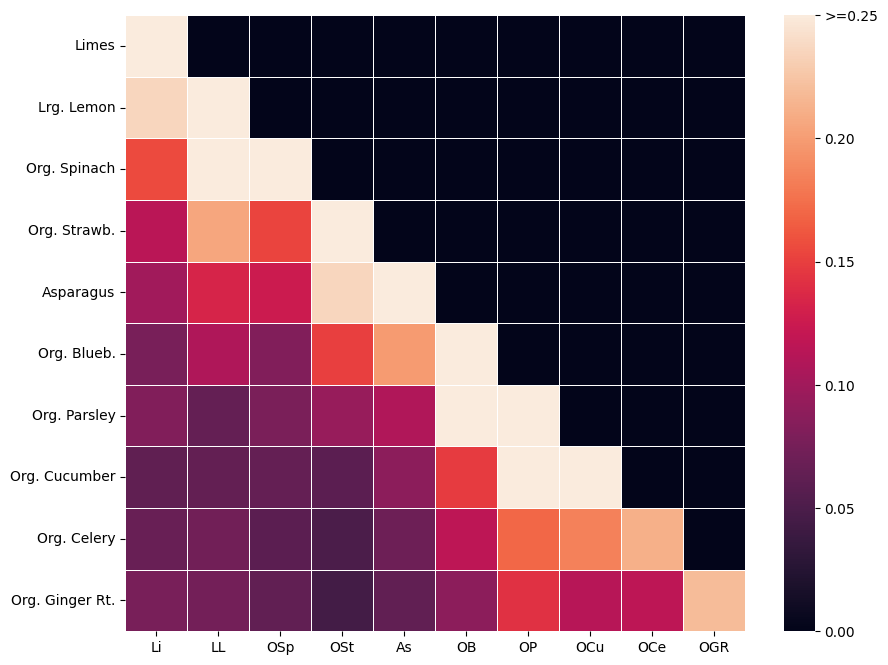

In [176]:
plt.figure(figsize=(10, 8))
temp_clipped = np.clip(temp, None, 0.25)
ax = sns.heatmap(temp_clipped, annot=False, linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(['0.00', '0.05', '0.10', '0.15', '0.20', '>=0.25'])
plt.xticks(rotation=0)
plt.show()

In [177]:
temp = pd.DataFrame(np.mean(attention_scores_2, axis = 1)[np.arange(10), np.arange(10)]).iloc[:, :10]
temp.columns = basket_abb
temp.index = basket

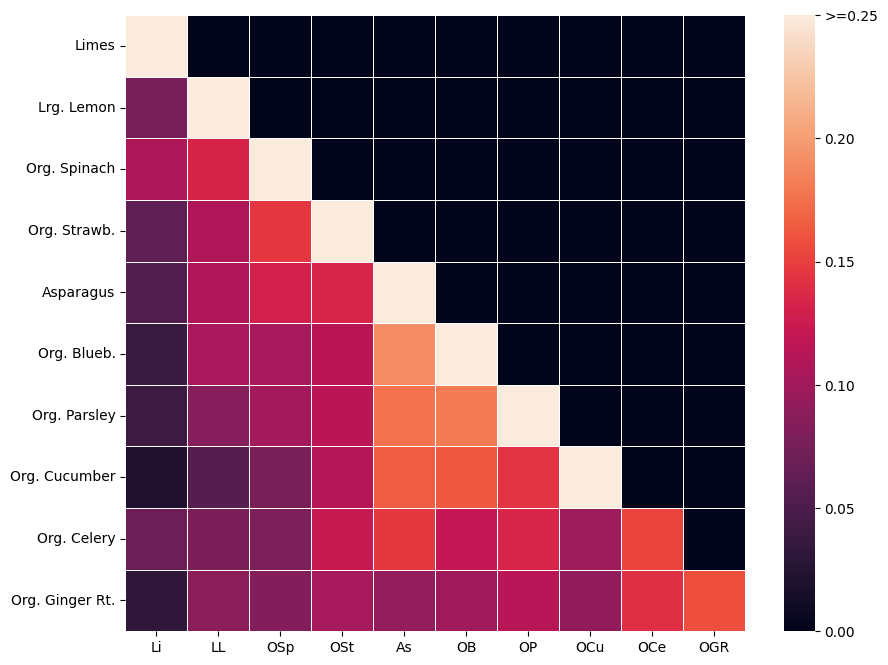

In [178]:
plt.figure(figsize=(10, 8))
temp_clipped = np.clip(temp, None, 0.25)
ax = sns.heatmap(temp_clipped, annot=False, linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(['0.00', '0.05', '0.10', '0.15', '0.20', '>=0.25'])
plt.xticks(rotation=0)
plt.show()

In [184]:
new_context_input = test_context_input[50:60]
new_masked_idx_input = test_target_input[50:60]

attention_scores_1, attention_scores_2 = get_attention_scores(model, new_context_input, new_masked_idx_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


In [185]:
basket = [31, 18,  1, 24, 14, 38, 33, 13, 49, 9]

basket = [all_products[i-1] for i in basket]

In [186]:
basket

['Banana',
 'Strawberries',
 'Organic Baby Spinach',
 'Organic Fuji Apple',
 'Red Vine Tomato',
 'Cucumber Kirby',
 'Original Hummus',
 'Limes',
 'Yellow Onions',
 'Organic Garnet Sweet Potato (Yam)']

In [187]:
basket = ['Banana', 'Strawb.', 'Org. Spinach', 'Org. Apple', 'Red Tomato', 'Cucumber', 'Orig. Hummus', 'Limes',
          'Ylw. Onions', 'Org. Yam']
basket_abb = ['Ba', 'St', 'OSp', 'OA', 'RT', 'Cu', 'OH', 'Li', 'YO', 'OY']

In [188]:
temp = pd.DataFrame(np.mean(attention_scores_1, axis = 1)[np.arange(10), np.arange(10)]).iloc[:, :10]
temp.columns = basket_abb
temp.index = basket

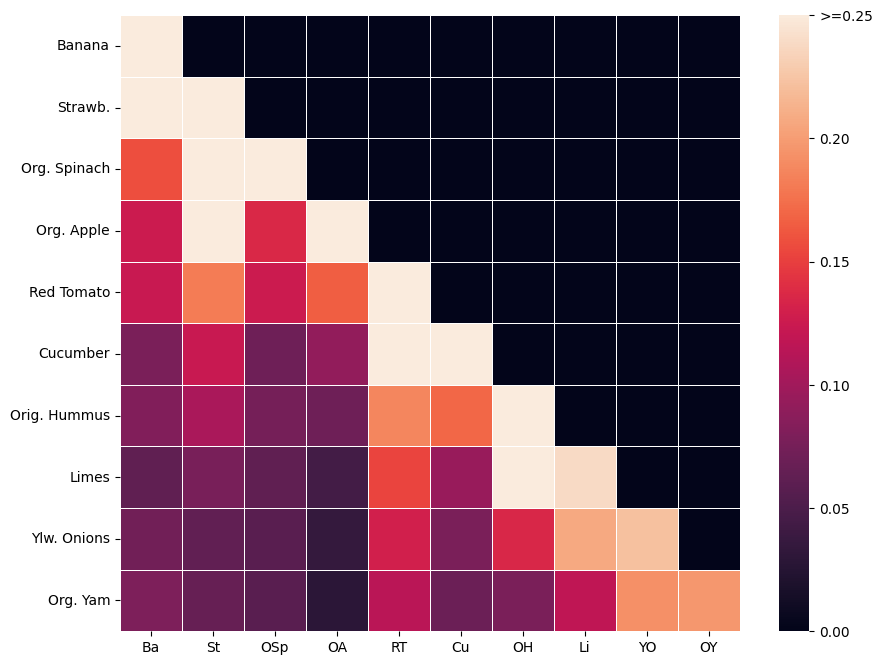

In [189]:
plt.figure(figsize=(10, 8))
temp_clipped = np.clip(temp, None, 0.25)
ax = sns.heatmap(temp_clipped, annot=False, linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(['0.00', '0.05', '0.10', '0.15', '0.20', '>=0.25'])
plt.xticks(rotation=0)
plt.show()

In [190]:
temp = pd.DataFrame(np.mean(attention_scores_2, axis = 1)[np.arange(10), np.arange(10)]).iloc[:, :10]
temp.columns = basket_abb
temp.index = basket

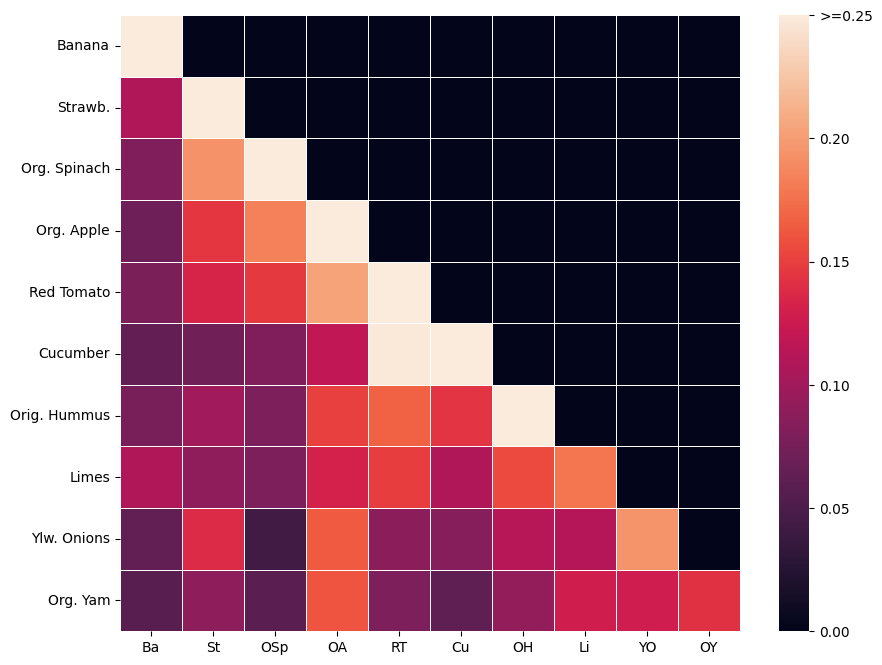

In [191]:
plt.figure(figsize=(10, 8))
temp_clipped = np.clip(temp, None, 0.25)
ax = sns.heatmap(temp_clipped, annot=False, linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(['0.00', '0.05', '0.10', '0.15', '0.20', '>=0.25'])
plt.xticks(rotation=0)
plt.show()

**VISUALIZING THE THREE EMBEDDINGS**

In [203]:
context_emb = model.get_layer("alpha_embedding").get_weights()[0][1:-1,:]

In [209]:
wq = model.get_layer("multi_head_attention_1").get_weights()[0]
wqb = model.get_layer("multi_head_attention_1").get_weights()[1]
wk = model.get_layer("multi_head_attention_1").get_weights()[2]
wkb = model.get_layer("multi_head_attention_1").get_weights()[3]
wv = model.get_layer("multi_head_attention_1").get_weights()[4]
wvb = model.get_layer("multi_head_attention_1").get_weights()[5]

In [226]:
q1 = pd.DataFrame(np.matmul(context_emb, wq[:,0,:]) + wqb[0,:])
k1 = pd.DataFrame(np.matmul(context_emb, wk[:,0,:]) + wkb[0,:])
v1 = pd.DataFrame(np.matmul(context_emb, wv[:,0,:]) + wvb[0,:])

q2 = pd.DataFrame(np.matmul(context_emb, wq[:,1,:]) + wqb[1,:])
k2 = pd.DataFrame(np.matmul(context_emb, wk[:,1,:]) + wkb[1,:])
v2 = pd.DataFrame(np.matmul(context_emb, wv[:,1,:]) + wvb[1,:])

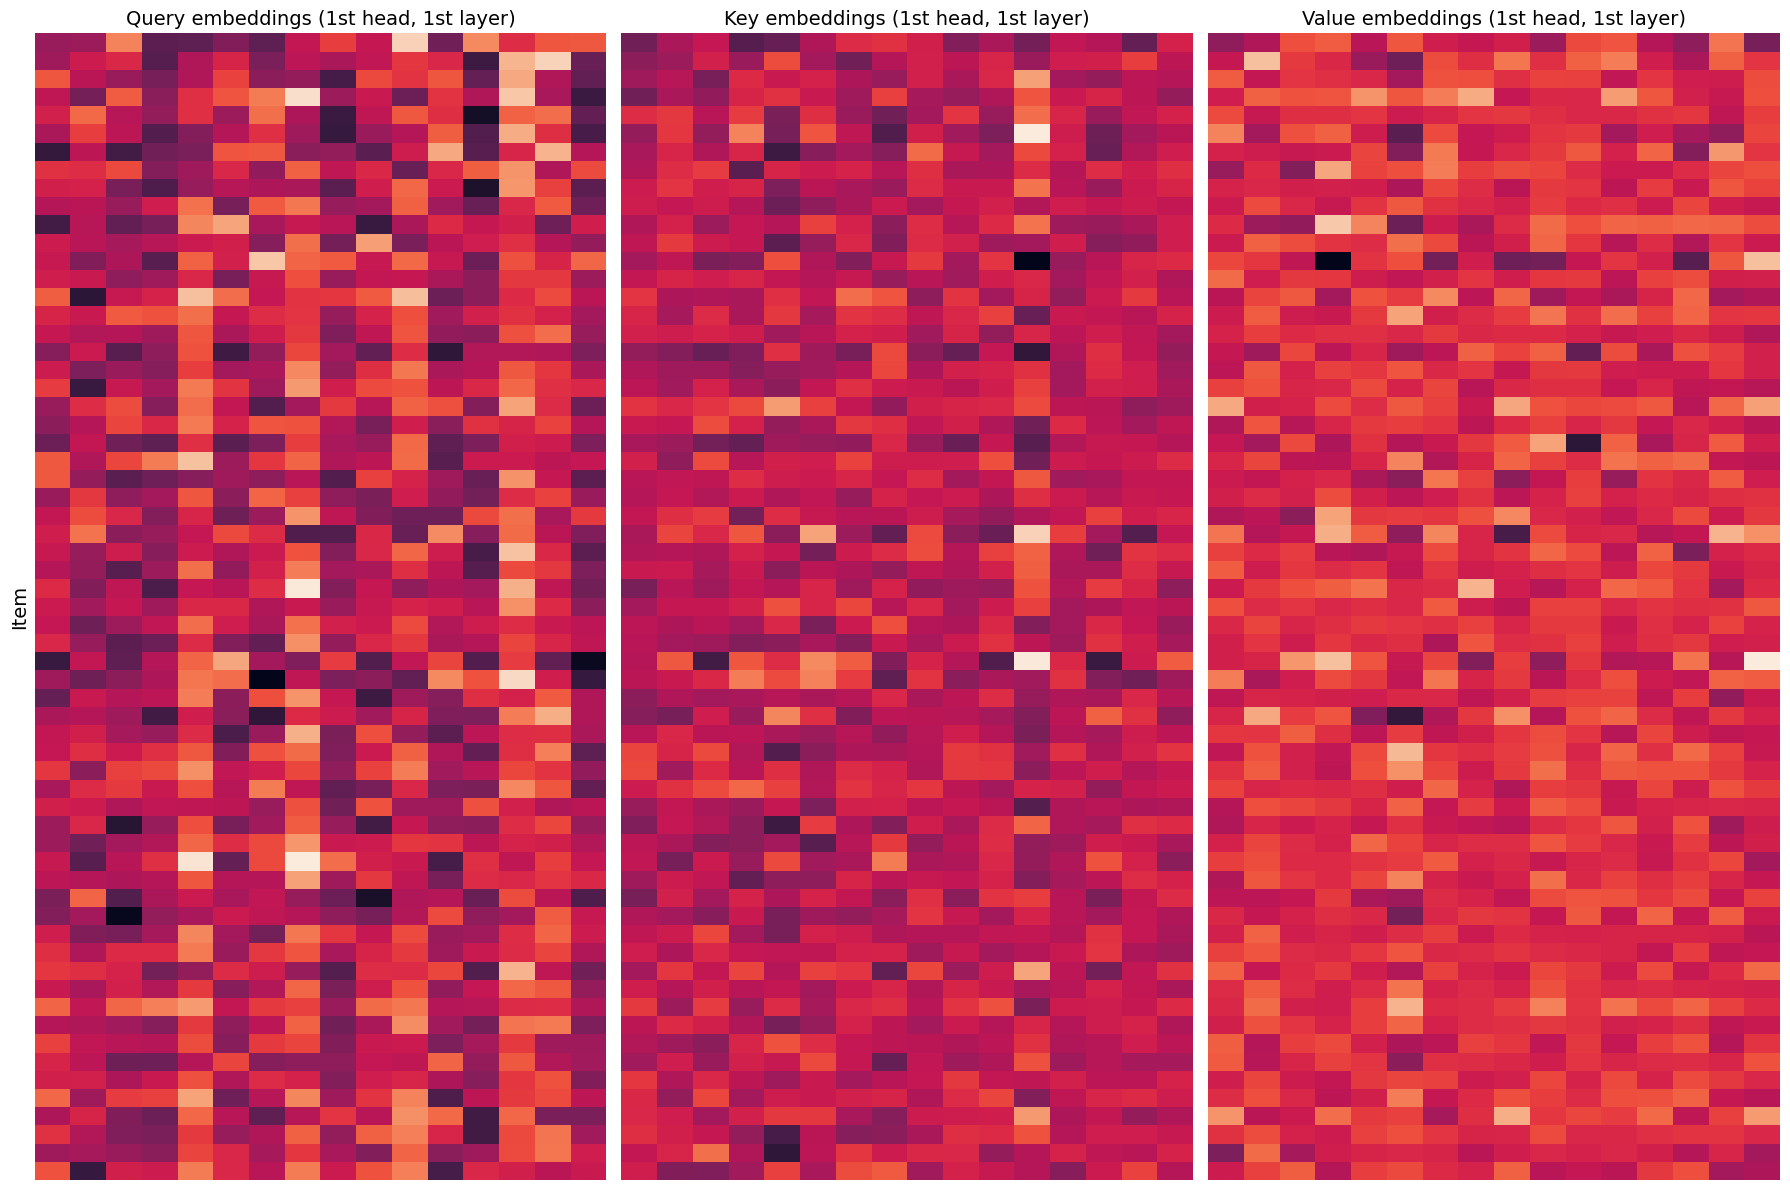

In [252]:
fig, axes = plt.subplots(1, 3, figsize=(18, 12))

sns.heatmap(q1, annot=False, linewidths=0, ax=axes[0], cbar=False)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_ylabel('Item', fontsize=14)
axes[0].set_title('Query embeddings (1st head, 1st layer)', fontsize=14)

sns.heatmap(k1, annot=False, linewidths=0, ax=axes[1], cbar=False)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Key embeddings (1st head, 1st layer)', fontsize=14)

sns.heatmap(v1, annot=False, linewidths=0, ax=axes[2], cbar=False)

axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Value embeddings (1st head, 1st layer)', fontsize=14)

plt.tight_layout()
plt.show()

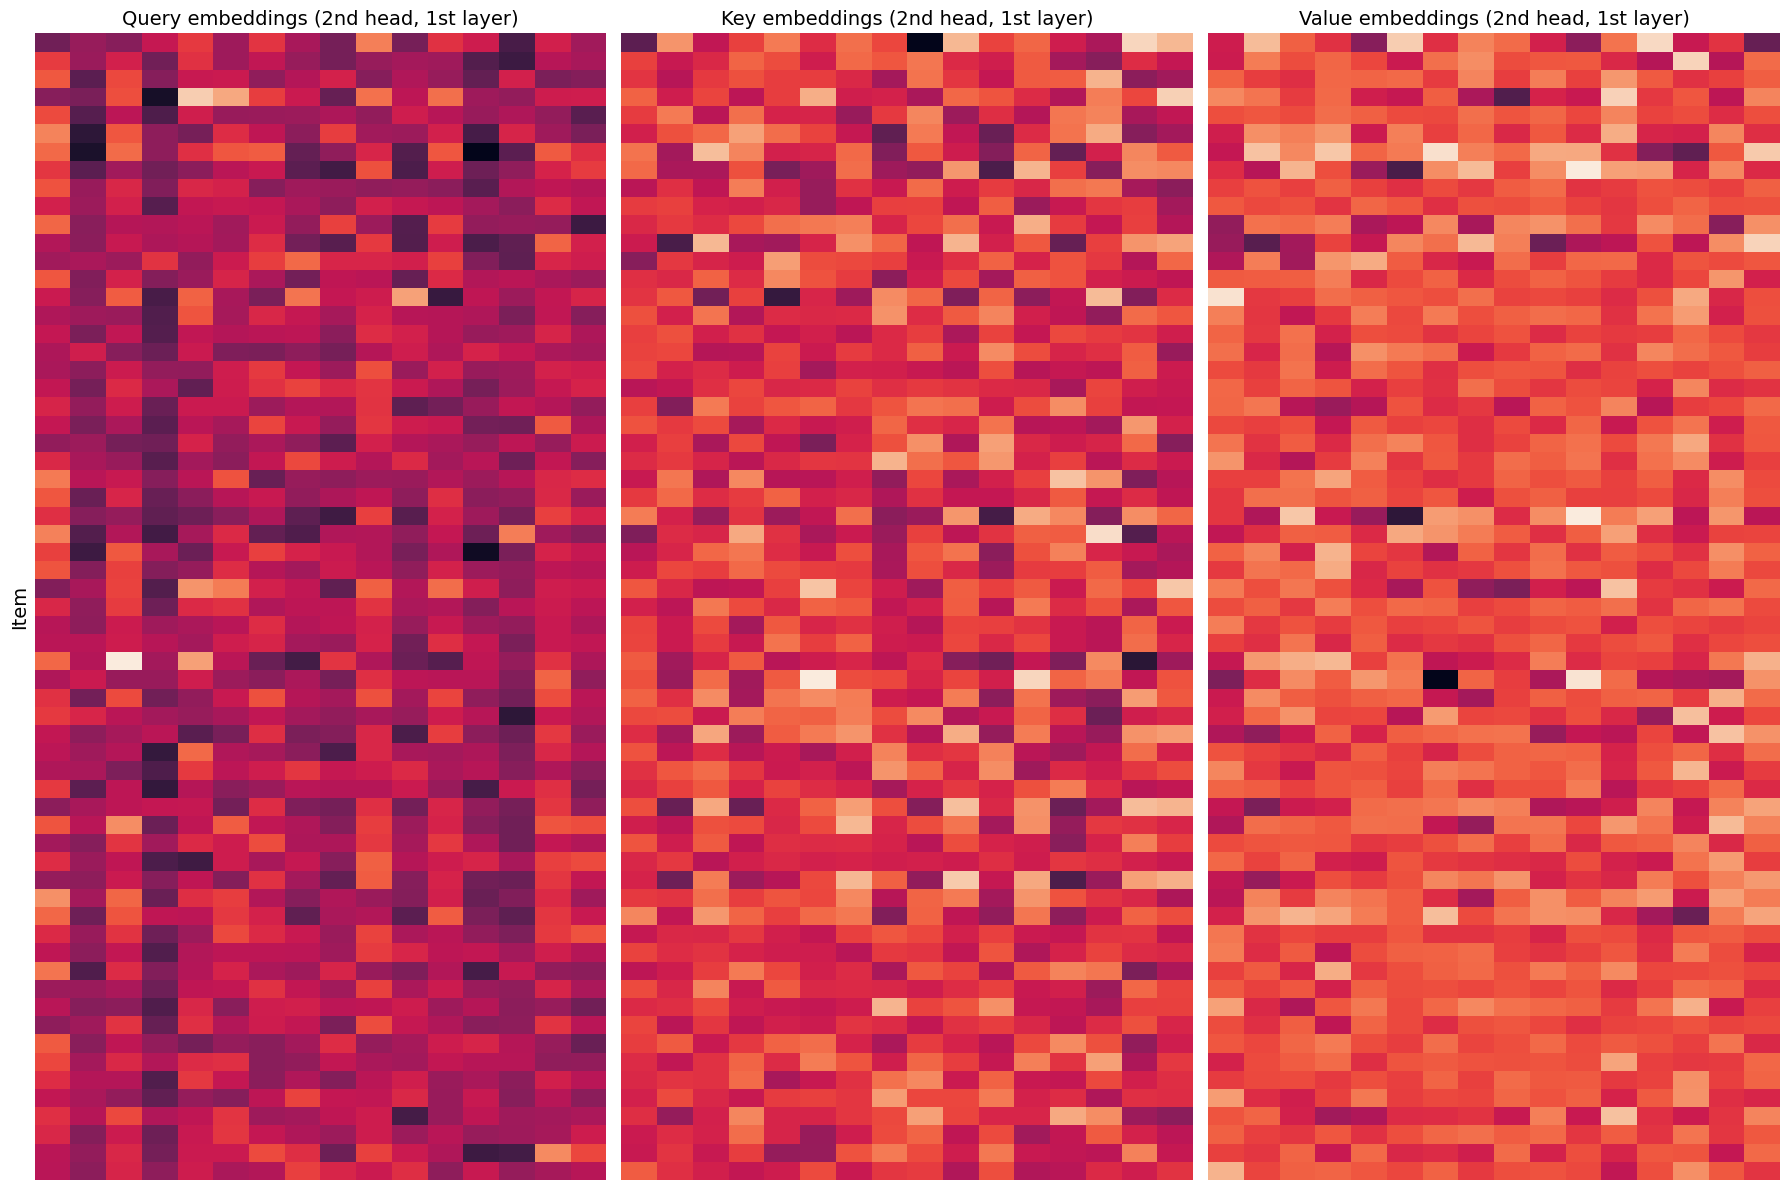

In [253]:
fig, axes = plt.subplots(1, 3, figsize=(18, 12))

sns.heatmap(q2, annot=False, linewidths=0, ax=axes[0], cbar=False)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_ylabel('Item', fontsize=14)
axes[0].set_title('Query embeddings (2nd head, 1st layer)', fontsize=14)

sns.heatmap(k2, annot=False, linewidths=0, ax=axes[1], cbar=False)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Key embeddings (2nd head, 1st layer)', fontsize=14)

sns.heatmap(v2, annot=False, linewidths=0, ax=axes[2], cbar=False)

axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Value embeddings (2nd head, 1st layer)', fontsize=14)

plt.tight_layout()
plt.show()